This notebook is an implementation of the methodology as described in the paper (*Building a Lemmatized corpus from documents varying in volume and average word length*). 

In [1]:
import os
import sys
import json
import nltk
import string
from dask import dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time as curr_time
from multiprocessing import cpu_count
from threading import Thread
from tqdm.notebook import tqdm
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

import findspark
findspark.init('C:/Users/Gebruiker/Desktop/spark/spark-3.0.0-preview2-bin-hadoop2.7')
import pyspark
findspark.find()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

nltk.download('wordnet')

curr_dir = os.getcwd()

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gebruiker\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Dataset
The implementation of the paper will be performed on a 200k English plaintext jokes dataset. (clone the repository from: https://github.com/taivop/joke-dataset and discard any files other than the .json ones).

In [ ]:
def read_data(global_df, filepath=["reddit", "stupidstuff", "wocka"]):
    for file in filepath: 
        print(file)
        with open(os.path.join(curr_dir, "dataset", file+".json")) as json_file:
            jokes = json.load(json_file)
            for joke in tqdm(jokes):
                global_df = global_df.append({'corpus': joke['body']}, ignore_index=True)
    return global_df

In [2]:
global_df = pd.DataFrame({'corpus': []})

if not os.path.exists(os.path.join(curr_dir, "raw_df.pkl")):
    global_df = read_data(global_df)
else:
    global_df = pd.read_pickle("tokenized_df.pkl")

In [ ]:
#global_df.to_pickle("raw_df.pkl")

In [ ]:
global_df.head()

In [ ]:
# Tokenize every document
global_df['corpus'] = global_df['corpus'].apply(lambda x : word_tokenize(x))

In [ ]:
# remove punctuation
global_df['corpus'] = global_df['corpus'].apply(lambda x : [''.join(c for c in s if c not in string.punctuation) for s in x])

In [ ]:
# average word length
global_df['avg_word_length'] = global_df['corpus'].apply(lambda x : len(x))

In [ ]:
#global_df.to_pickle("tokenized_df.pkl")

In [3]:
global_df.head()

,corpus,avg_word_length
0,"[Now, I, have, to, say, , Leroy, can, you, ple...",15
1,"[Pizza, does, nt, scream, when, you, put, it, ...",17
2,"[, and, being, there, really, helped, me, lear...",42
3,"[A, Sunday, school, teacher, is, concerned, th...",126
4,"[He, got, caught, trying, to, sell, the, two, ...",13


In [4]:
subset_varying_wordLength = {}
subset_varying_documents = None
plot_number_of_documents = {}

ranges = [1,20,30,40,50,60,70,80,90,100]

for index, start_range in enumerate(ranges):
    end_range = None
    if index + 1 == len(ranges):
        break
    else:
        end_range = ranges[index + 1]
    subset_varying_wordLength[str(start_range) + '-' + str(end_range)] = None
    plot_number_of_documents[str(start_range) + '-' + str(end_range)] = None
    
subset_varying_wordLength

{'1-20': None,
 '20-30': None,
 '30-40': None,
 '40-50': None,
 '50-60': None,
 '60-70': None,
 '70-80': None,
 '80-90': None,
 '90-100': None}

In [5]:
for subset in subset_varying_wordLength.keys():
    start, end = subset.split('-')
    subset_varying_wordLength[subset] = global_df[(global_df['avg_word_length'] > int(start)) & (global_df['avg_word_length'] < int(end))]

subset_varying_documents = subset_varying_wordLength['1-20'].copy()

In [6]:
for category, df in subset_varying_wordLength.items(): 
    num_rows = int(df.shape[0])
    plot_number_of_documents[category] = num_rows
    if num_rows > 2000:
        df.drop(df.tail(num_rows-2000).index,inplace=True)

C:\Users\Gebruiker\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
# Check if all subsets do contain the same amount of rows
for category, df in subset_varying_wordLength.items(): 
    print(df.shape[0])

2000
2000
2000
2000
2000
2000
2000
2000
2000


In [8]:
plot_number_of_documents

{'1-20': 141335,
 '20-30': 12598,
 '30-40': 6928,
 '40-50': 5027,
 '50-60': 3753,
 '60-70': 3229,
 '70-80': 2804,
 '80-90': 2791,
 '90-100': 2380}

In [9]:
subset_varying_documents.shape[0]

141335

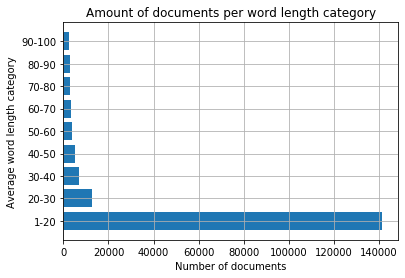

In [10]:
plt.barh(range(len(plot_number_of_documents)), list(plot_number_of_documents.values()), align='center')
plt.yticks(range(len(plot_number_of_documents)), list(plot_number_of_documents.keys()))
plt.xlabel("Number of documents")
plt.ylabel("Average word length category")
plt.title("Amount of documents per word length category")
plt.grid(True)
plt.show()

# METHOD 1: Native Python & Pandas

In [11]:
globalLemmaInstance = WordNetLemmatizer()
method_1_native_execution_results_threads_1 = {
    "document_size": {
        "global":{
            '1k': None,
            '10k': None,
            '25k': None,
            '50k': None,
            '75k': None,
            '100k': None
        },
        "no_global": {
            '1k': None,
            '10k': None,
            '25k': None,
            '50k': None,
            '75k': None,
            '100k': None
        }
    },
    "document_length": {
        "global":{
            '1-20': None,
            '20-30': None,
            '30-40': None,
            '40-50': None,
            '50-60': None,
            '60-70': None,
            '70-80': None,
            '80-90': None,
            '90-100': None
        },
        "no_global": {
            '1-20': None,
            '20-30': None,
            '30-40': None,
            '40-50': None,
            '50-60': None,
            '60-70': None,
            '70-80': None,
            '80-90': None,
            '90-100': None
        }
    }
}

method_1_native_execution_results_threads_6 = {
    "document_size": {
        "global":{
            '1k': None,
            '10k': None,
            '25k': None,
            '50k': None,
            '75k': None,
            '100k': None
        },
        "no_global": {
            '1k': None,
            '10k': None,
            '25k': None,
            '50k': None,
            '75k': None,
            '100k': None
        }
    },
    "document_length": {
        "global":{
            '1-20': None,
            '20-30': None,
            '30-40': None,
            '40-50': None,
            '50-60': None,
            '60-70': None,
            '70-80': None,
            '80-90': None,
            '90-100': None
        },
        "no_global": {
            '1-20': None,
            '20-30': None,
            '30-40': None,
            '40-50': None,
            '50-60': None,
            '60-70': None,
            '70-80': None,
            '80-90': None,
            '90-100': None
        }
    }
}

method_1_native_execution_results_threads_12 = {
    "document_size": {
        "global":{
            '1k': None,
            '10k': None,
            '25k': None,
            '50k': None,
            '75k': None,
            '100k': None
        },
        "no_global": {
            '1k': None,
            '10k': None,
            '25k': None,
            '50k': None,
            '75k': None,
            '100k': None
        }
    },
    "document_length": {
        "global":{
            '1-20': None,
            '20-30': None,
            '30-40': None,
            '40-50': None,
            '50-60': None,
            '60-70': None,
            '70-80': None,
            '80-90': None,
            '90-100': None
        },
        "no_global": {
            '1-20': None,
            '20-30': None,
            '30-40': None,
            '40-50': None,
            '50-60': None,
            '60-70': None,
            '70-80': None,
            '80-90': None,
            '90-100': None
        }
    }
}

In [12]:
# Different methods for instance in and instance out method

def native_lemma_with_global(corpus_list):
    global globalLemmaInstance
    return [globalLemmaInstance.lemmatize(w) for w in corpus_list]

def native_lemma_no_global(corpus_list):
    return [WordNetLemmatizer().lemmatize(w) for w in corpus_list]

In [13]:
def allocate_function(df, option):
    if option == "global":
        df['corpus'].apply(native_lemma_with_global)
    else:
        df['corpus'].apply(native_lemma_no_global)
    return None

In [14]:
def method_1_execution():
    result_variabels = {1: method_1_native_execution_results_threads_1, 
               6: method_1_native_execution_results_threads_6, 
               12: method_1_native_execution_results_threads_12}
    
    for param, results in result_variabels.items():
        print(param)
        for methodology_name, methodology in results.items():
            for option_name, option in methodology.items():
                for subset_name, time in option.items():
                    subset = None
                    if methodology_name == "document_size":
                        subset = subset_varying_documents
                        subset_size = int(str(subset_name).replace('k', '000'))
                        if int(subset.shape[0]) > subset_size:
                            subset = subset.drop(subset.tail(subset.shape[0]-subset_size).index,inplace=False)
                    elif methodology_name == "document_length":
                        subset = subset_varying_wordLength[subset_name]
                    # Divide subset in subsequent sets for multithreaded processing
                    subset = np.array_split(subset, param)
                    # Execute code
                    threadList = []
                    for sub_subset in subset:
                        threadList.append(Thread(target=allocate_function, args=(sub_subset, option_name,)))
                    # Start timing
                    start_time = curr_time()
                    [t.start() for t in threadList]
                    [t.join() for t in threadList]
                    # Wait for all threads to be finished
                    end_time = curr_time()
                    total_time = end_time-start_time
                    # Print results
                    print(methodology_name, option_name, subset_name)
                    print("TIME => ", end_time-start_time)
                    results[methodology_name][option_name][subset_name] = total_time
                    
method_1_execution()

1
document_size global 1k
TIME =>  1.6871833801269531
document_size global 10k
TIME =>  0.22440028190612793
document_size global 25k
TIME =>  0.5505237579345703
document_size global 50k
TIME =>  1.706441879272461
document_size global 75k
TIME =>  1.6296412944793701
document_size global 100k
TIME =>  2.17138671875
document_size no_global 1k
TIME =>  0.024939537048339844
document_size no_global 10k
TIME =>  0.2291874885559082
document_size no_global 25k
TIME =>  0.8447411060333252
document_size no_global 50k
TIME =>  1.138918161392212
document_size no_global 75k
TIME =>  1.6982083320617676
document_size no_global 100k
TIME =>  2.569162130355835
document_length global 1-20
TIME =>  0.05288100242614746
document_length global 20-30
TIME =>  0.13167905807495117
document_length global 30-40
TIME =>  0.2932395935058594
document_length global 40-50
TIME =>  0.3104534149169922
document_length global 50-60
TIME =>  0.3092060089111328
document_length global 60-70
TIME =>  0.35887861251831055
docum

In [17]:
method_1_native_execution_results_threads_1

{'document_size': {'global': {'1k': 2.0635018348693848,
   '10k': 0.23151087760925293,
   '25k': 0.9166853427886963,
   '50k': 1.514270544052124,
   '75k': 2.215592384338379,
   '100k': 3.3148200511932373},
  'no_global': {'1k': 0.03027033805847168,
   '10k': 0.44136571884155273,
   '25k': 0.7835352420806885,
   '50k': 1.5565781593322754,
   '75k': 2.406491994857788,
   '100k': 3.5768182277679443}},
 'document_length': {'global': {'1-20': 0.06361556053161621,
   '20-30': 0.1892855167388916,
   '30-40': 0.2698187828063965,
   '40-50': 0.34710168838500977,
   '50-60': 0.4178917407989502,
   '60-70': 0.4782836437225342,
   '70-80': 0.5631232261657715,
   '80-90': 0.6974043846130371,
   '90-100': 0.730827808380127},
  'no_global': {'1-20': 0.061629533767700195,
   '20-30': 0.19988727569580078,
   '30-40': 0.32787156105041504,
   '40-50': 0.3567626476287842,
   '50-60': 0.42339587211608887,
   '60-70': 0.4819643497467041,
   '70-80': 0.6068432331085205,
   '80-90': 0.6174502372741699,
   '9

# METHOD 2: Dask and Spark

Convert the pandas DataFrame to a Spark DataFrame with the createDataFrame method. Remember using the createDataFrame method to convert an RDD to a Spark DataFrame?

In [18]:
method_2_spark = {
    "document_size": {
        "global":{
            '1k': None,
            '10k': None,
            '25k': None,
            '50k': None,
            '75k': None,
            '100k': None
        },
        "no_global": {
            '1k': None,
            '10k': None,
            '25k': None,
            '50k': None,
            '75k': None,
            '100k': None
        }
    },
    "document_length": {
        "global":{
            '1-20': None,
            '20-30': None,
            '30-40': None,
            '40-50': None,
            '50-60': None,
            '60-70': None,
            '70-80': None,
            '80-90': None,
            '90-100': None
        },
        "no_global": {
            '1-20': None,
            '20-30': None,
            '30-40': None,
            '40-50': None,
            '50-60': None,
            '60-70': None,
            '70-80': None,
            '80-90': None,
            '90-100': None
        }
    }
}

method_2_dask = {
    "document_size": {
        "global":{
            '1k': None,
            '10k': None,
            '25k': None,
            '50k': None,
            '75k': None,
            '100k': None
        },
        "no_global": {
            '1k': None,
            '10k': None,
            '25k': None,
            '50k': None,
            '75k': None,
            '100k': None
        }
    },
    "document_length": {
        "global":{
            '1-20': None,
            '20-30': None,
            '30-40': None,
            '40-50': None,
            '50-60': None,
            '60-70': None,
            '70-80': None,
            '80-90': None,
            '90-100': None
        },
        "no_global": {
            '1-20': None,
            '20-30': None,
            '30-40': None,
            '40-50': None,
            '50-60': None,
            '60-70': None,
            '70-80': None,
            '80-90': None,
            '90-100': None
        }
    }
}

In [19]:
def allocate_function_dask(df, option):
    if option == "global":
        df['corpus'].apply(native_lemma_with_global, meta=('corpus', 'object'))
    else:
        df['corpus'].apply(native_lemma_no_global, meta=('corpus', 'object'))
    return None

def allocate_function_spark(df, option):
    if option == "global":
        df.rdd.map(native_lemma_with_global)
    else:
        df.rdd.map(native_lemma_no_global)
    return None

In [20]:
def method_2_execution():
    result_variabels = {"dask": method_2_dask, "spark": method_2_spark}
    
    for library, results in result_variabels.items():
        print(library)
        for methodology_name, methodology in results.items():
            for option_name, option in methodology.items():
                for subset_name, time in option.items():
                    subset = None
                    if methodology_name == "document_size":
                        subset = subset_varying_documents
                        subset_size = int(str(subset_name).replace('k', '000'))
                        if int(subset.shape[0]) > subset_size:
                            subset = subset.drop(subset.tail(subset.shape[0]-subset_size).index,inplace=False)
                    elif methodology_name == "document_length":
                        subset = subset_varying_wordLength[subset_name]
                    # Load engine into corresponding library
                    start_time = None
                    if library == "dask":
                        subset = dd.from_pandas(subset, 6)
                        # Start timing
                        start_time = curr_time()
                        # Dask method
                        allocate_function_dask(subset, option_name)
                    elif library == "spark":
                        subset = spark.createDataFrame(subset)
                        subset = subset.select("corpus")
                        # Start timing
                        start_time = curr_time()
                        # Spark method                    
                        allocate_function_spark(subset, option_name)
                    # Wait for all threads to be finished
                    end_time = curr_time()
                    total_time = end_time-start_time
                    # Print results
                    print(methodology_name, option_name, subset_name)
                    print("TIME => ", end_time-start_time)
                    results[methodology_name][option_name][subset_name] = float(total_time)
                    
method_2_execution()

dask
document_size global 1k
TIME =>  0.0016682147979736328
document_size global 10k
TIME =>  0.0
document_size global 25k
TIME =>  0.0
document_size global 50k
TIME =>  0.000997781753540039
document_size global 75k
TIME =>  0.0009975433349609375
document_size global 100k
TIME =>  0.001993894577026367
document_size no_global 1k
TIME =>  0.0009996891021728516
document_size no_global 10k
TIME =>  0.0009965896606445312
document_size no_global 25k
TIME =>  0.000997304916381836
document_size no_global 50k
TIME =>  0.002034902572631836
document_size no_global 75k
TIME =>  0.0019948482513427734
document_size no_global 100k
TIME =>  0.0019943714141845703
document_length global 1-20
TIME =>  0.000997304916381836
document_length global 20-30
TIME =>  0.0020220279693603516
document_length global 30-40
TIME =>  0.0009992122650146484
document_length global 40-50
TIME =>  0.0010256767272949219
document_length global 50-60
TIME =>  0.000997304916381836
document_length global 60-70
TIME =>  0.00199460

In [22]:
method_2_spark

{'document_size': {'global': {'1k': 0.6368584632873535,
   '10k': 0.031242847442626953,
   '25k': 0.031241893768310547,
   '50k': 0.015621185302734375,
   '75k': 0.015621185302734375,
   '100k': 0.03233766555786133},
  'no_global': {'1k': 0.015621662139892578,
   '10k': 0.031243562698364258,
   '25k': 0.02094411849975586,
   '50k': 0.01795196533203125,
   '75k': 0.022714614868164062,
   '100k': 0.01670980453491211}},
 'document_length': {'global': {'1-20': 0.031241893768310547,
   '20-30': 0.01004934310913086,
   '30-40': 0.031281471252441406,
   '40-50': 0.02393651008605957,
   '50-60': 0.015622377395629883,
   '60-70': 0.020062923431396484,
   '70-80': 0.030259370803833008,
   '80-90': 0.01817154884338379,
   '90-100': 0.01559901237487793},
  'no_global': {'1-20': 0.0030214786529541016,
   '20-30': 0.015620946884155273,
   '30-40': 0.01994633674621582,
   '40-50': 0.019974231719970703,
   '50-60': 0.03239774703979492,
   '60-70': 0.03121495246887207,
   '70-80': 0.015650510787963867,

# Plots

In [16]:
data = {
    "native_thread_1": method_1_native_execution_results_threads_1,
    "native_thread_6": method_1_native_execution_results_threads_6,
    "native_thread_12": method_1_native_execution_results_threads_12,
    "dask": method_2_dask,
    "spark": method_2_spark
}

## Create plots for document length

### Method 1 (native)

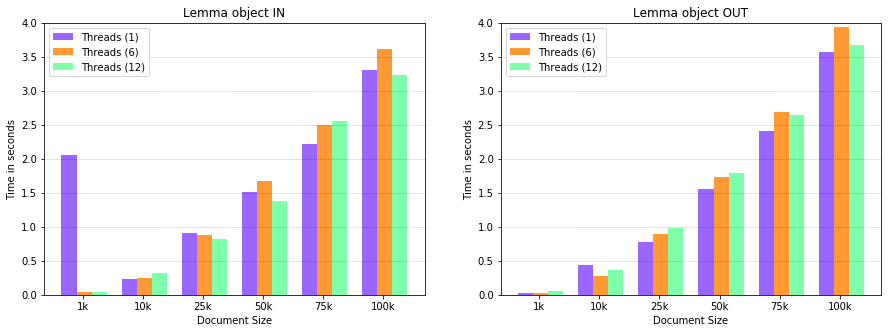

In [99]:
length = 6
x_labels = list(data['native_thread_1']['document_size']['global'].keys())

# Set plot parameters
fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle("Measure time execution times for varying document sizes - Method 1")
fig.set_size_inches(15.0, 5.0, forward=True)
width = 0.25 # width of bar

x = np.arange(length)
ax1.bar(x, np.asarray(list(data['native_thread_1']['document_size']['global'].values())), width, color='#9966ff', label='Threads (1)')
ax1.bar(x + width, np.asarray(list(data['native_thread_6']['document_size']['global'].values())), width, color='#ff9933', label='Threads (6)')
ax1.bar(x + (2 * width), np.asarray(list(data['native_thread_12']['document_size']['global'].values())), width, color='#80ffaa', label='Threads (12)')

ax1.set_ylabel('Time in seconds')
ax1.set_ylim(0,4)
ax1.set_xticks(x + width + width/2 - 0.15)
ax1.set_xticklabels(x_labels)
ax1.set_xlabel('Document Size')
ax1.set_title('Lemma object IN')
ax1.legend()
ax1.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

ax2.bar(x, np.asarray(list(data['native_thread_1']['document_size']['no_global'].values())), width, color='#9966ff', label='Threads (1)')
ax2.bar(x + width, np.asarray(list(data['native_thread_6']['document_size']['no_global'].values())), width, color='#ff9933', label='Threads (6)')
ax2.bar(x + (2 * width), np.asarray(list(data['native_thread_12']['document_size']['no_global'].values())), width, color='#80ffaa', label='Threads (12)')

ax2.set_ylabel('Time in seconds')
ax2.set_ylim(0,4)
ax2.set_xticks(x + width + width/2 - 0.15)
ax2.set_xticklabels(x_labels)
ax2.set_xlabel('Document Size')
ax2.set_title('Lemma object OUT')
ax2.legend()
ax2.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

### Big data

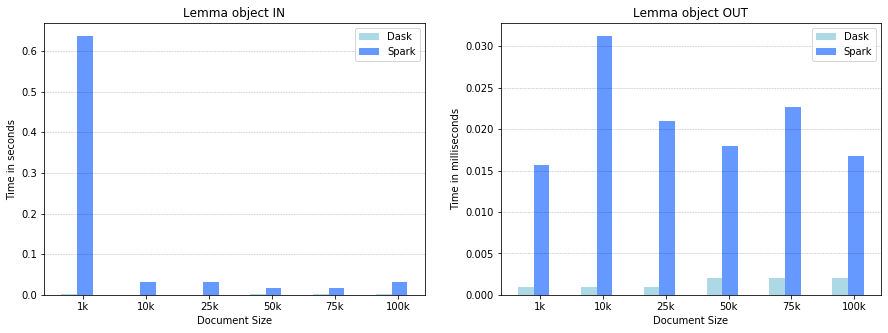

In [100]:
length = 6
x_labels = list(data['dask']['document_size']['global'].keys())

# Set plot parameters
fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle("Measure time execution times for varying document sizes - Method 2")
fig.set_size_inches(15.0, 5.0, forward=True)
width = 0.25 # width of bar

x = np.arange(length)
ax1.bar(x, np.asarray(list(data['dask']['document_size']['global'].values())), width, color='lightblue', label='Dask')
ax1.bar(x + width, np.asarray(list(data['spark']['document_size']['global'].values())), width, color='#6699ff', label='Spark')

ax1.set_ylabel('Time in seconds')
ax1.set_xticks(x + width + width/2 - 0.15)
ax1.set_xticklabels(x_labels)
ax1.set_xlabel('Document Size')
ax1.set_title('Lemma object IN')
ax1.legend()
ax1.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

ax2.bar(x, np.asarray(list(data['dask']['document_size']['no_global'].values())), width, color='lightblue', label='Dask')
ax2.bar(x + width, np.asarray(list(data['spark']['document_size']['no_global'].values())), width, color='#6699ff', label='Spark')

ax2.set_ylabel('Time in milliseconds')
ax2.set_xticks(x + width + width/2 - 0.15)
ax2.set_xticklabels(x_labels)
ax2.set_xlabel('Document Size')
ax2.set_title('Lemma object OUT')
ax2.legend()
ax2.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

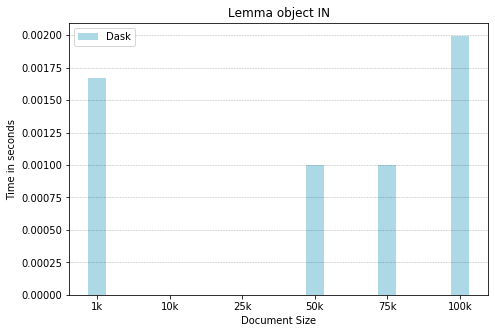

In [101]:
length = 6
x_labels = list(data['dask']['document_size']['global'].keys())

# Set plot parameters
fig, (ax1) = plt.subplots(1, 1)
# fig.suptitle("Measure time execution times for varying document sizes - Method 2 - Dask Only")
fig.set_size_inches(7.5, 5.0, forward=True)
width = 0.25 # width of bar

x = np.arange(length)
ax1.bar(x, np.asarray(list(data['dask']['document_size']['global'].values())), width, color='lightblue', label='Dask')
# ax1.bar(x + width, np.asarray(list(data['spark']['document_size']['global'].values())), width, color='#6699ff', label='Spark')

ax1.set_ylabel('Time in seconds')
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels)
ax1.set_xlabel('Document Size')
ax1.set_title('Lemma object IN')
ax1.legend()
ax1.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

## Create plots for document avg word sizes

### Method 1 (native)

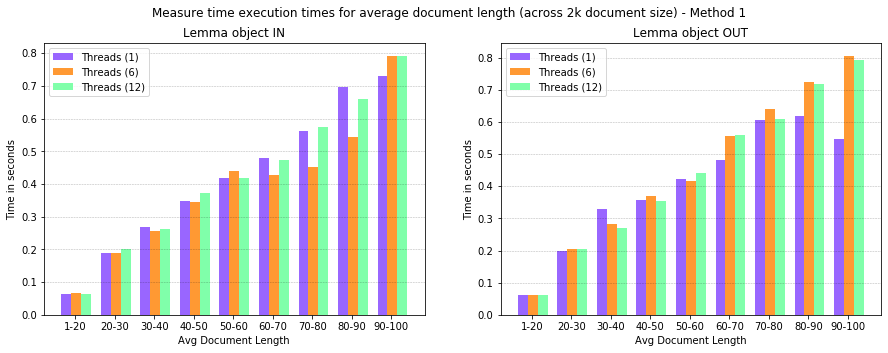

In [80]:
length = 9
x_labels = list(data['native_thread_1']['document_length']['global'].keys())

# Set plot parameters
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Measure time execution times for average document length (across 2k document size) - Method 1")
fig.set_size_inches(15.0, 5.0, forward=True)
width = 0.25 # width of bar

x = np.arange(length)
ax1.bar(x, np.asarray(list(data['native_thread_1']['document_length']['global'].values())), width, color='#9966ff', label='Threads (1)')
ax1.bar(x + width, np.asarray(list(data['native_thread_6']['document_length']['global'].values())), width, color='#ff9933', label='Threads (6)')
ax1.bar(x + (2 * width), np.asarray(list(data['native_thread_12']['document_length']['global'].values())), width, color='#80ffaa', label='Threads (12)')

ax1.set_ylabel('Time in milliseconds')
ax1.set_xticks(x + width + width/2 - 0.15)
ax1.set_xticklabels(x_labels)
ax1.set_xlabel('Avg Document Length')
ax1.set_title('Lemma object IN')
ax1.legend()
ax1.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

ax2.bar(x, np.asarray(list(data['native_thread_1']['document_length']['no_global'].values())), width, color='#9966ff', label='Threads (1)')
ax2.bar(x + width, np.asarray(list(data['native_thread_6']['document_length']['no_global'].values())), width, color='#ff9933', label='Threads (6)')
ax2.bar(x + (2 * width), np.asarray(list(data['native_thread_12']['document_length']['no_global'].values())), width, color='#80ffaa', label='Threads (12)')

ax2.set_ylabel('Time in milliseconds')
ax2.set_xticks(x + width + width/2 - 0.15)
ax2.set_xticklabels(x_labels)
ax2.set_xlabel('Avg Document Length')
ax2.set_title('Lemma object OUT')
ax2.legend()
ax2.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

### Method 2 (big data)

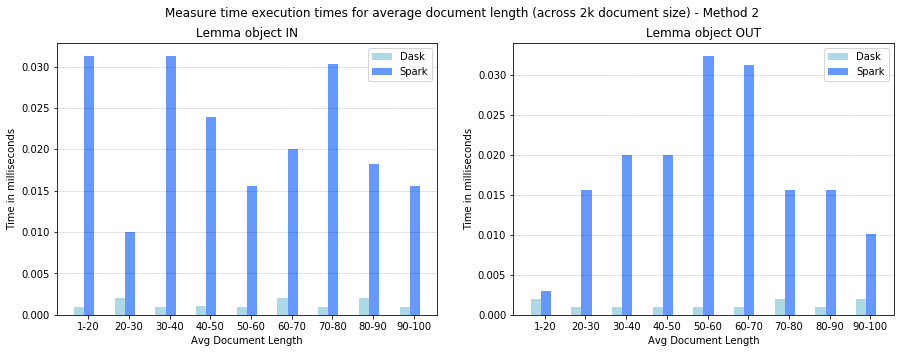

In [84]:
length = 9
x_labels = list(data['dask']['document_length']['global'].keys())

# Set plot parameters
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Measure time execution times for average document length (across 2k document size) - Method 2")
fig.set_size_inches(15.0, 5.0, forward=True)
width = 0.25 # width of bar

x = np.arange(length)
ax1.bar(x, np.asarray(list(data['dask']['document_length']['global'].values())), width, color='lightblue', label='Dask')
ax1.bar(x + width, np.asarray(list(data['spark']['document_length']['global'].values())), width, color='#6699ff', label='Spark')

ax1.set_ylabel('Time in milliseconds')
ax1.set_xticks(x + width + width/2 - 0.15)
ax1.set_xticklabels(x_labels)
ax1.set_xlabel('Avg Document Length')
ax1.set_title('Lemma object IN')
ax1.legend()
ax1.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

ax2.bar(x, np.asarray(list(data['dask']['document_length']['no_global'].values())), width, color='lightblue', label='Dask')
ax2.bar(x + width, np.asarray(list(data['spark']['document_length']['no_global'].values())), width, color='#6699ff', label='Spark')

ax2.set_ylabel('Time in milliseconds')
ax2.set_xticks(x + width + width/2 - 0.15)
ax2.set_xticklabels(x_labels)
ax2.set_xlabel('Avg Document Length')
ax2.set_title('Lemma object OUT')
ax2.legend()
ax2.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)